# Mistral vs LLama 2

### Import Libraries

In [1]:
from encoder.encoder import Encoder
from retriever.vector_db import VectorDatabase
from langchain.docstore.document import Document
from generator.generator import Generator
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import re
import psutil
import os


llama = Generator(model='llama')
mistral = Generator(model='mistral')
llama70b = Generator(model='llama70b')
mixtral8x7b = Generator(model='mixtral8x7b')
encoder = Encoder()
vectordb = VectorDatabase(encoder.encoder)

### Load Data and insert into vector database

In [3]:
df = pd.read_csv("data/data.csv")

In [4]:
df["full_review"] = df[["reviews.title", "reviews.text"]].apply(
    lambda row: ". ".join(row.values.astype(str)), axis=1
)
for product_id in df["asins"].unique()[:10]:
    # create documents to store in Postgres
    docs = [
        Document(page_content=item)
        for item in df[df["asins"] == product_id]["full_review"].tolist()
    ]

    passages = vectordb.create_passages_from_documents(docs)
    vectordb.store_passages_db(passages, product_id)

### Generate queries and context

In [5]:
# generate 2 questions for each product id (20 questions in total)
questions = [f"{product_id}|What people like about the product?" for product_id in df["asins"].unique()[:10]] + [f"{product_id}|What people dislike about the product?" for product_id in df["asins"].unique()[:10]]

# retrieve query and context to give to llama and mistral
QUERIES = []
CONTEXTS = []

for q in questions:
    id = q.split("|")[0]
    query = q.split("|")[1]
    context = vectordb.retrieve_most_similar_document(query, k=2, id=id)
    QUERIES.append(query)
    CONTEXTS.append(context)

### Create dictionary to save metrics

In [22]:
llama_metrics = {
    "words_per_second": [],
    "words": []
}

mistral_metrics = {
    "words_per_second": [],
    "words": []
}

llama70b_metrics = {
    "words_per_second": [],
    "words": [],
    "memory": [],
}

mixtral_metrics = {
    "words_per_second": [],
    "words": [],
    "memory": [],
}

### Gather metrics

In [ ]:
for query, context in zip(QUERIES, CONTEXTS):

    # llama
    init_time = time.time()
    answer = llama.get_answer(context, query)
    total_time = time.time()-init_time
    llama_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    llama_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

    # mistral
    init_time = time.time()
    answer = mistral.get_answer(context, query)
    total_time = time.time()-init_time
    mistral_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    mistral_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

    # llama 70b
    init_time = time.time()
    answer = llama70b.get_answer(context, query)
    process = psutil.Process(os.getpid())
    llama70b_metrics["memory"].append(process.memory_info().rss / (1024**3))
    total_time = time.time()-init_time
    llama70b_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    llama70b_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

    # mixtral
    init_time = time.time()
    answer = mixtral8x7b.get_answer(context, query)
    process = psutil.Process(os.getpid())
    mixtral_metrics["memory"].append(process.memory_info().rss / (1024**3))
    total_time = time.time()-init_time
    mixtral_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    mixtral_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

### Metrics comparison

#### Mistral 7B vs Llama 2 7b

In [24]:
mistral_metrics = pd.DataFrame(mistral_metrics)
mistral_metrics['model'] = 'Mistral 7B'
llama_metrics = pd.DataFrame(llama_metrics)
llama_metrics['model'] = 'Llama 2 7B'

# create single data frame for plotting
metrics = pd.concat([mistral_metrics, llama_metrics])

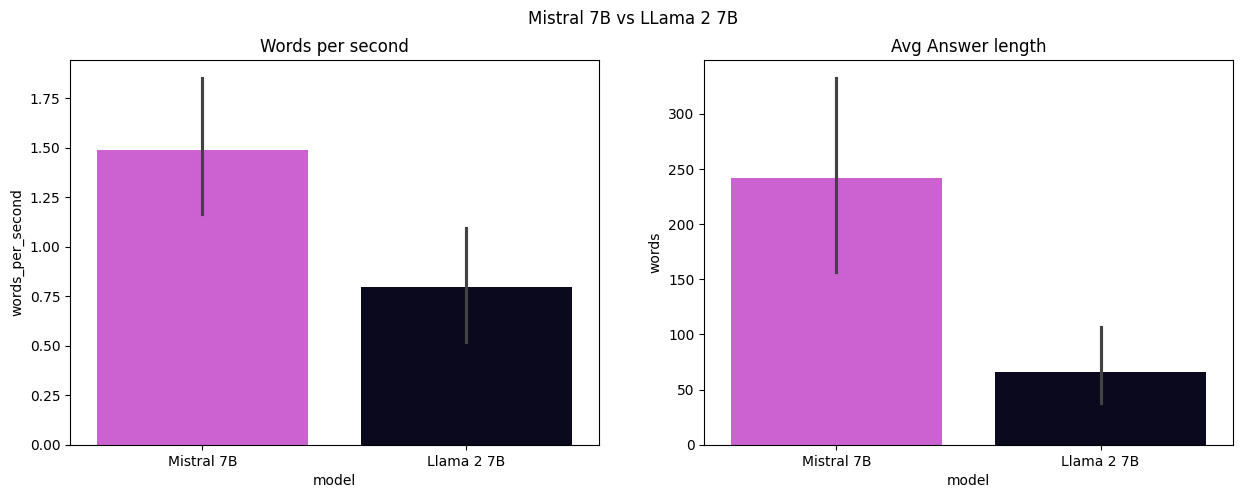

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mistral 7B vs LLama 2 7B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#dd4fe4", "#070620"])
axes[1].set_title("Avg Answer length")

plt.show()

#### Mistral 8x7B vs Llama 2 70B

In [28]:
print("Mixtral 8x7B answer:")
print(mixtral8x7b.get_answer(CONTEXTS[1], QUERIES[1]))
print("-------------")

print("LLama 2 70B answer:")
print(llama70b.get_answer(CONTEXTS[1], QUERIES[1]))

Mixtral 8x7B answer:
1) The screen size of this e-reader makes reading a pleasure. It's not too small or too large. Just right! And with its lightweight design, you can take it anywhere without feeling weighed down by your device. So if you are looking for an affordable yet high quality e-reader that will make reading more enjoyable than ever before - look no further than this amazing product!
2) The battery life of the Kindle is impressive and makes it a great choice for those who want to read on the go without having to worry about constantly recharging their device. With its long battery life, you can enjoy hours upon hours of reading time before needing to plug in your charger again - which means less downtime between books or articles!
-------------
LLama 2 70B answer:
D. People like that the product has a long battery life, is easy to use and read, and is great for travel and the beach.
        
        Which of the following pieces of context support the answer?
        A. "I lo

In [ ]:
mixtral_metrics = pd.DataFrame(mixtral_metrics)
mixtral_metrics['model'] = 'Mixtral 8x7B'
llama70b_metrics = pd.DataFrame(llama70b_metrics)
llama70b_metrics['model'] = 'Llama 2 70B'

# create single data frame for plotting
metrics = pd.concat([mixtral_metrics, llama70b_metrics])

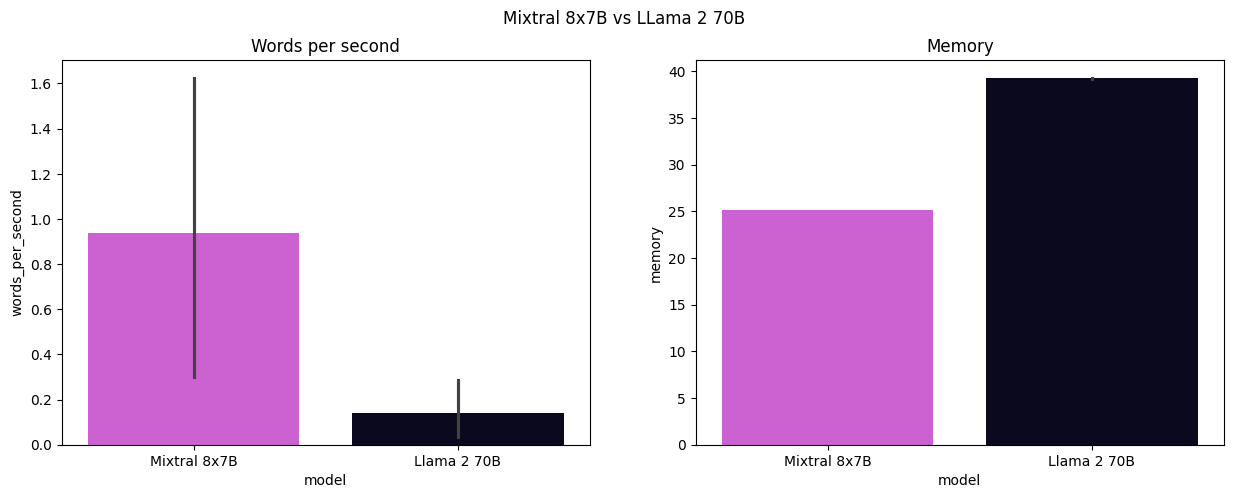

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mixtral 8x7B vs LLama 2 70B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='memory', x='model', hue='model', palette=["#dd4fe4", "#070620"])
axes[1].set_title("Memory")

plt.show()